## Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## theory of pipeline
The pipeline is included by multiple functions,
they are camera calibration, etc...


The code for this step is contained in the fourth the cell of the IPython notebook located in "p2.ipynb"

In [1]:
#import necessary package
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

np.set_printoptions(threshold=10000)

## Camera Calibration

### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

First of all I created the funciton to detect the calibration image can be detected by cv2.findChessboardCorners()

In [2]:
#checking if the image is detectedable
def check_detectable(img,nx,ny):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(img, (nx,ny), None)
    print ret

False
True


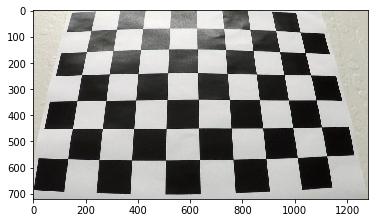

In [101]:
img = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\test_images\test1.jpg')
chesseboard = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\camera_cal\calibration3.jpg')
plt.imshow(chesseboard)
objpoints = [] # 3D points in real life
imgpoints = [] # 2D points in image

#checking if the image is detectedable
check_detectable(img,9,6)
check_detectable(chesseboard,9,6)

Then, the images after detection will be started by copy the original image as 'undist', and I convert the image format into gray format, then I use the _cv2.findChessboardCorners_ to confirm the chessboard corners coordination (x, y, z) which are imgae points. then I define the object points (x,y,z) which are the order of chessboard corners order, e.g. (0, 0, 0), (1, 0, 0) until (8, 5, 0) and here we just assume the z equals zero during the whole conversion.

once we get the image points on imput pictures and object points, by using _cv2.calibrateCamera_ function we can get the distortion parameters, mtx, dist, rvecs, tvecs, then using _cv2.undistort_ can get the undistorted picture.

finally we can use these parameters to calibrate the road images.

In [4]:
#没用上，project提供的照片不需要undistort
# using on camera calibration, undistort image and unwarp intersted area of image 
# returns the undistorted/unwarped image

#Formatting
#img should be read my plt.imread, make sure it's BGR format
#objpoints & imgpoints are empty list

#unwarp chessboardcorners的一个方程，在实际应用中直接选取road的四个点来unwarp，这个是用来矫正camera的
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        perspective_img = cv2.warpPerspective(undist, M, img_size)
        return perspective_img, M
    
    else:
        print('cant find distorted image points')

    # Return the resulting image and matrix
    
    
def cal_undistort_unwarped(img, objpoints, imgpoints, nx=9, ny=6):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = np.copy(img)  # Delete this line
    undist_gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    
    #define image object points
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    ret, corners = cv2.findChessboardCorners(undist_gray, (nx,ny), None)

    #if function detects the chessboard points, append two set of points into the original set
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
    else:
        print('cant find image corners')
        
    cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, undist_gray.shape[::-1], None, None)
    undistorted = cv2.undistort(undist, mtx, dist, None, mtx)
    
    #using corners_unwarp to transform the image 
    
    warped,M = corners_unwarp(img, nx, ny, mtx, dist)
    
    return undistorted, warped, M, mtx, dist


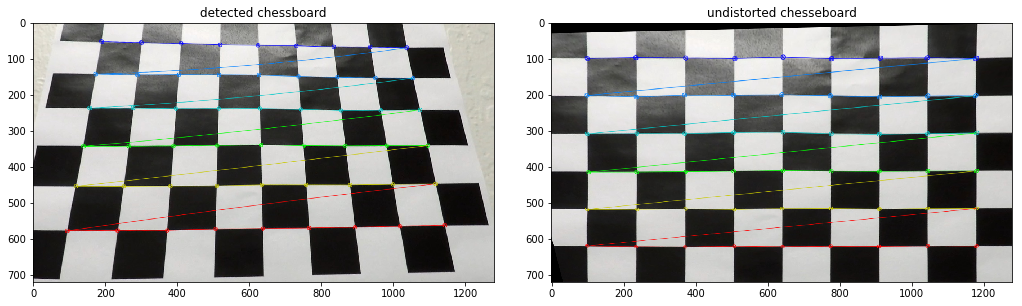

In [7]:
# getting all undistortion chessboard image
chesseboard = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\camera_cal\calibration3.jpg')

undistorted, warped, M, mtx,dist = cal_undistort_unwarped(chesseboard, objpoints, imgpoints)


fig = plt.figure(figsize=(16,5))
ax1 = fig.add_axes([0.05,0.05,0.40,0.95])
ax1.imshow(undistorted)
ax1.set_title('detected chessboard')
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
# plt.subplot(121)
ax2 = fig.add_axes([0.5,0.05,0.4,0.95])
ax2.imshow(warped)
ax2.set_title('undistorted chesseboard')
# plt.imshow(undistorted_road)
# plt.subplot(122)
fig.savefig('chesseboard_comparison.jpg')

By using the camera matrix and distortion coefficients, the undistorted road can be generated.

The function roadimg_unwarp is defined for this purpose.
The differences between two roads can be found by the edges of camera

In [102]:
#unwarp the actual road pic from camera
def roadimg_unwarp(img, mtx, dist):
    undist = np.copy(img)
    undistorted = cv2.undistort(undist, mtx, dist, None, mtx)
    
    return undistorted

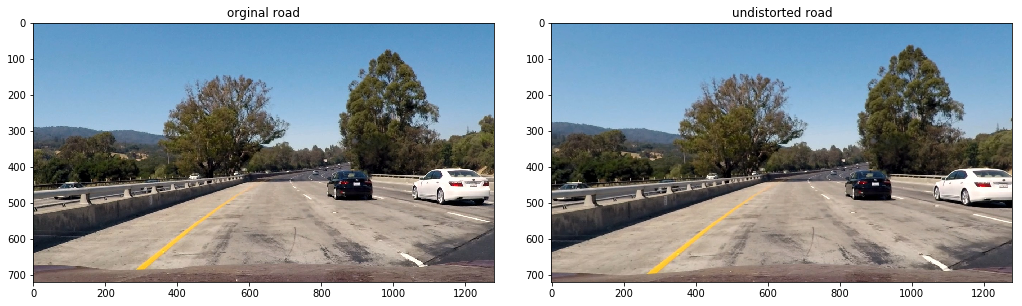

In [103]:
undistorted_road = roadimg_unwarp(img, mtx, dist)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_axes([0.05,0.05,0.40,0.95])
ax1.imshow(img)
ax1.set_title('orginal road')
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
# plt.subplot(121)
ax2 = fig.add_axes([0.5,0.05,0.4,0.95])
ax2.imshow(undistorted_road)
ax2.set_title('undistorted road')
# plt.imshow(undistorted_road)
# plt.subplot(122)
fig.savefig('road_comparison.jpg')

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

Based on the above function, I get the camera matrix and distortion coefficients from camera calibration image, then I write own region masking function to filter out unnecessary part of road and only keep useful part.

then I use the blend the camera matrix and distortion coefficients with filtered road image together and use cv2.undistort in function named: roadimg_unwarp to get perspective image.

After I get the perspective image of road, I used a combination of absolute sobel gradients threshold along x, y direction, sobel gradients magitude threshold, sobel gradients direction threshold and HLS channel threshold, I tried multiple value combo and figure out the most confident threshold valve value, belows are the threshold value selection step by step.

In [16]:
#testing insterested region area
#最开始的一步，用来maksing感兴趣的照片的地方
# img = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\test_images\test6.jpg')
# Pull out the x and y sizes and make a copy of the image
def region_mask(img):
    ysize = img.shape[0]
    xsize = img.shape[1]
    img_line = np.copy(img)
    region_select = np.copy(img)

    # Define a triangle region of interest 
    # Keep in mind the origin (x=0, y=0) is in the upper left in image processing
    # Note: if you run this code, you'll find these are not sensible values!!
    # But you'll get a chance to play with them soon in a quiz 
    left_bottom = [140, ysize]
    right_bottom = [1230, ysize]
    left_top = [530, 460]
    right_top = [780, 460]

    # Fit lines (y=Ax+B) to identify the  3 sided region of interest
    # np.polyfit() returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], left_top[0]), (left_bottom[1], left_top[1]), 1)
    fit_right = np.polyfit((right_bottom[0], right_top[0]), (right_bottom[1], right_top[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1], right_top[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1])) & \
                        (YY > (XX*fit_top[0] + fit_top[1]))

#     # Color pixels red which are inside the region of interest
#     cv2.line(img_line, tuple(left_bottom), tuple(left_top), [255,0,0], 5)
#     cv2.line(img_line, tuple(right_bottom), tuple(right_top), [255,0,0], 5)
#     cv2.line(img_line, tuple(left_top), tuple(right_top), [255,0,0], 5)
#     cv2.line(img_line, tuple(left_bottom), tuple(right_bottom), [255,0,0], 5)

    region_select[~region_thresholds] = [0, 0, 0]
    
    #using these to compare the orginal image and masking region area
#     fig = plt.figure()
#     ax1 = fig.add_axes([0,0,3,1])
#     ax2 = fig.add_axes([0,1.2,3,1])

#     ax1.imshow(img)
#     ax2.imshow(region_select)

 
    return region_select
    

In [17]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return grad_binary

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return mag_binary

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1
    
    # Return the binary image
    return dir_binary

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh_min=0, thresh_max=255):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    hls_binary = np.zeros_like(s_channel)
    hls_binary[(s_channel > thresh_min) & (s_channel <= thresh_max)] = 1
    return hls_binary

#combine the three different thresholds: x,y direction, magitude and maximum gradient direction 
def combine_threshold(image, ksize=3, grad_rangex=[0,255], grad_rangey=[0,255], mag_range=[0,255], dir_range=[0, np.pi/2], hls_range=[0,255]):
    # Apply each of the thresholding functions
    # x,y direction value of gradient threshold
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh_min=grad_rangex[0], thresh_max=grad_rangex[1])
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh_min=grad_rangey[0], thresh_max=grad_rangey[1])
    
    #magitude of gradient threshold
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh_min=mag_range[0], thresh_max=mag_range[1])
    
    #direction of maximum gradient threshold
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh_min=dir_range[0], thresh_max=dir_range[1])
    
    #filter by hls 
    hls_binary = hls_select(image,thresh_min=hls_range[0], thresh_max=hls_range[1])
    
    combined__binary = np.zeros_like(dir_binary)
    combined__binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
    
    #plot two figures together
    #use to compare orginal pic and filterized pic
#     fig = plt.figure()
#     ax1 = fig.add_axes([0,1.2,3,1])
#     ax2 = fig.add_axes([0,0,3,1])
#     ax1.imshow(image)
#     ax2.imshow(combined__binary, cmap='gray')
 
    return combined__binary

Define combine_fig and combine_binaryfig functions to present the images and bianry images together

In [33]:
# provide image output function
def save_fig(img, img_name):
    fig = plt.figure(figsize=(7,4))
    ax1 = fig.add_axes([0.05,0.1,0.95,0.85])
    ax1.imshow(img)
    ax1.set_title(img_name)
    filename = raw_input()+'.jpg'
    fig.savefig(filename)

#img1_name, img2_name are string value
#combine two images to one and output it
def combine_fig(img1, img2, img1_name, img2_name):
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_axes([0.05,0.05,0.40,0.95])
    ax1.imshow(img1)
    ax1.set_title(img1_name)
    # now create a subplot which represents the top plot of a grid
    # with 2 rows and 1 column. Since this subplot will overlap the
    # first, the plot (and its axes) previously created, will be removed
    # plt.subplot(121)
    ax2 = fig.add_axes([0.5,0.05,0.4,0.95])
    ax2.imshow(img2)
    ax2.set_title(img2_name)
    # plt.imshow(undistorted_road)
    # plt.subplot(122)
    
    
    #unable the save fig function, because I only need to show them in jupyter notebook
#     filename = raw_input()+'.jpg'
#     fig.savefig(filename)

#img1_name, img2_name are string value
#combine two images to one and output it
def combine_binaryfig(img1, img2, img1_name, img2_name):
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_axes([0.05,0.05,0.40,0.95])
    ax1.imshow(img1, cmap='gray')
    ax1.set_title(img1_name)
    # now create a subplot which represents the top plot of a grid
    # with 2 rows and 1 column. Since this subplot will overlap the
    # first, the plot (and its axes) previously created, will be removed
    # plt.subplot(121)
    ax2 = fig.add_axes([0.5,0.05,0.4,0.95])
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(img2_name)
    # plt.imshow(undistorted_road)
    # plt.subplot(122)
    
    #unable the save fig function, because I only need to show them in jupyter notebook
#     filename = raw_input()+'.jpg'
#     fig.savefig(filename)

In [28]:
#makeing output for different threshold image
img = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\test_images\test1.jpg')
chesseboard = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\camera_cal\calibration3.jpg')

# doing camera calibration work
undistorted, warped, M, mtx,dist = cal_undistort_unwarped(chesseboard, objpoints, imgpoints)
undistorted_road = roadimg_unwarp(img, mtx, dist)

# formal transfrom road pic
road_mask = region_mask(undistorted_road)

gradx = abs_sobel_thresh(road_mask, orient='x', sobel_kernel=9, thresh_min=40, thresh_max=150)
grady = abs_sobel_thresh(road_mask, orient='y', sobel_kernel=9, thresh_min=40, thresh_max=70)

#magitude of gradient threshold
mag_binary = mag_thresh(road_mask, sobel_kernel=9, thresh_min=70, thresh_max=150)

#direction of maximum gradient threshold
dir_binary = dir_threshold(road_mask, sobel_kernel=9, thresh_min=np.pi/6, thresh_max=np.pi/2)

#filter by hls 
hls_binary = hls_select(road_mask,thresh_min=100, thresh_max=255)


combined__binary = combine_threshold(road_mask, ksize=9, grad_rangex=[40,150], grad_rangey=[70,150], mag_range=[70,150], dir_range=[np.pi/6, np.pi/2], hls_range=[100,255])


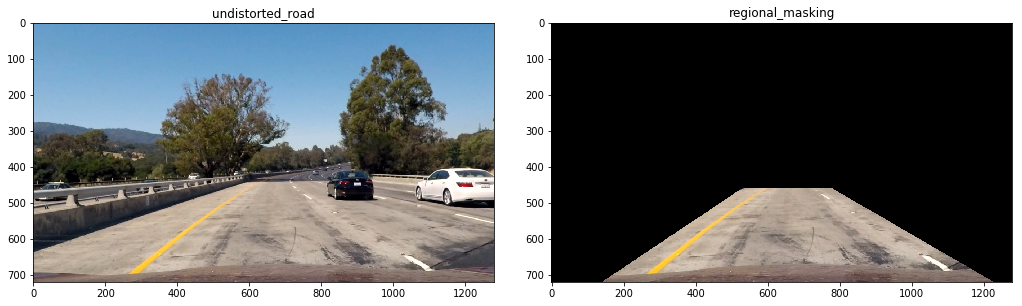

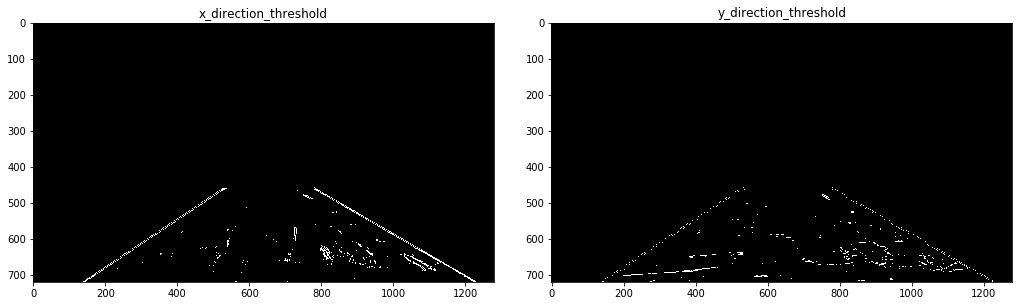

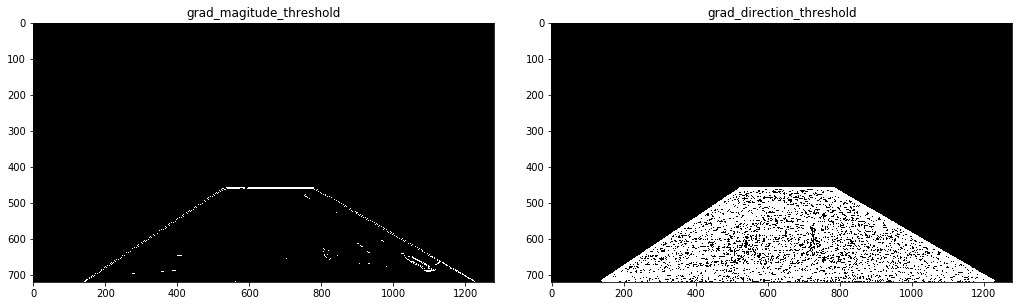

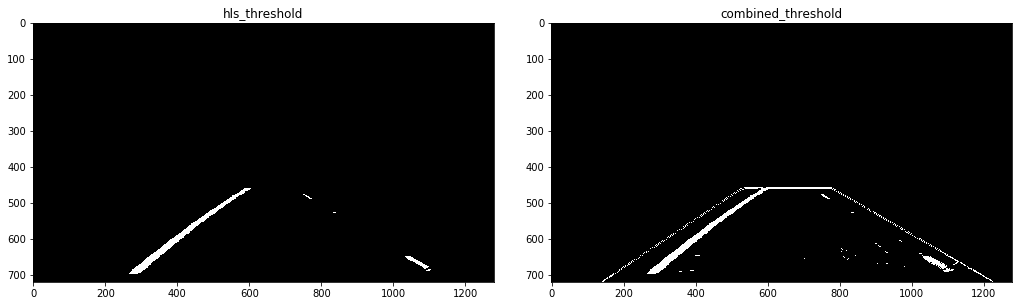

In [35]:
combine_fig(undistorted_road, road_mask, 'undistorted_road', 'regional_masking')

combine_binaryfig(gradx, grady, 'x_direction_threshold', 'y_direction_threshold')

combine_binaryfig(mag_binary, dir_binary, 'grad_magitude_threshold', 'grad_direction_threshold')

combine_binaryfig(hls_binary, combined__binary, 'hls_threshold', 'combined_threshold')

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

perspective transfrom function is conducted by  pres_trans(gray, offset=10)
first of all, the source points and destination points are hard coded as following:
```
offset = 10
source points:
    left_bottom = [140+offset, ysize]
    right_bottom = [1230-offset, ysize]
    left_top = [530+offset, 460+offset]
    right_top = [780-offset, 460+offset]
src = np.float32([left_bottom, right_bottom, left_top, right_top])
destition points:
    dst = np.float32([[0, ysize], [xsize, ysize], [0, 0], [xsize, 0]])
```

This resulted in the following source and destination points:


| Source        | Destination   | 
|:-------------:|:-------------:| 
| 150, 720      | 0, 720        | 
| 1220, 720     | 1280, 720     |
| 540, 470      | 0, 0          |
| 770, 470      | 1280, 0       |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

In [38]:
#prespective transform an undistorted GRAY image 

def pres_trans(gray, offset=10):

    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here

    #the import image has been distorted, gray
    # gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    xsize = gray.shape[1]
    ysize = gray.shape[0]

    #pick four source points from original camera pic
    #need to add offset to masking pic because white line is shown in gray masking pic
    left_bottom = [140+offset, ysize]
    right_bottom = [1230-offset, ysize]
    left_top = [530+offset, 460+offset]
    right_top = [780-offset, 460+offset]
    
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([left_bottom, right_bottom, left_top, right_top])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[0, ysize], [xsize, ysize], 
                       [0, 0], [xsize, 0]])
        #(100,100), , (1280-100, 720-100), (1280-100, 100)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(gray, M, img_size, flags=cv2.INTER_LINEAR)
    
    #plot two figures together
    #using to compare input image and prespective transform image
#     fig = plt.figure()
#     ax1 = fig.add_axes([0,1.2,3,1])
#     ax2 = fig.add_axes([0,0,3,1])
#     ax1.imshow(img)
#     ax2.imshow(warped, cmap='gray')
 
    # Return the resulting image and matrix
    return warped, M, Minv

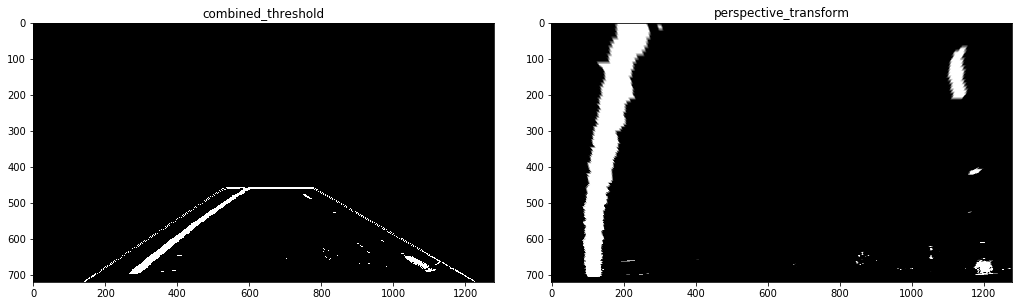

In [39]:
binary_warped, M, Minv = pres_trans(combined__binary)
combine_binaryfig(combined__binary, binary_warped, 'combined_threshold', 'perspective_transform')

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

first of all, prespective transfrom function will generate the output image as gray format, called as binary_warped,

Then by define the function called _find_lane_pixels(binary_warped)_, it will first sum up the pixel which value equals one in binary warped along the y axis, then find the two peaks on the left side and right side, we will assume these two peaks are the middle points of drive lines.

after inital the start point of driving lines, the image will be splited to 9 pieces horizontally, this is because the driving lines will have some cruvatures, so the middle points need update after every iterations, under this assumption, the middle points will be updated 9 times.

In every window of 9 windows splited before, all nonzero pixels, which will show white color in the image will be added multiple limitations by x, y coordinations, they are hard coded as below:
In the following coding, the leftx_current and rightx_current are the middle point of current window at left and right side.
```
win_y_low = binary_warped.shape[0] - (window+1)*window_height
win_y_hig = binary_warped.shape[0] - window*window_height
win_xleft_low = leftx_current - margin
win_xleft_high = leftx_current + margin
win_xright_low = rightx_current - margin
win_xright_high = rightx_current + margin
```

the filter will be added in the following method:
```
good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_hig                   h)).nonzero()[0]
good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_h                    igh)).nonzero()[0]
        
```

then all good pixels will be collected in the numpy array, and marked as red/blue color.

after all the iterations, we will get all good pixels in road, and by using function np.polyfit(), we can generate polynomial paramters for left/right driving lines, we split the image along the y direction evenly, and using the polynomial parameters to generate the x coordination and plot them on the image which are the polynomial curve for driving lines

In [114]:
def convert_gray2rgb(binary):
    rgb_component = np.uint8(binary*255)
    out_img = np.dstack((rgb_component, rgb_component, rgb_component))
    return out_img

#this function only take binary_warped pic from Prespective_transfrom function
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    # split the binary to half to sum following the y_axis to get sum_num of pixel amount of binary_warped pic
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    # Creating RGN pic from binary_warped gray pic, save it as later to use
    # Need to change binary pic which 1 stand for black change to RGB 255 range
    out_img = convert_gray2rgb(binary_warped)
    ori_out_img = np.copy(out_img)
#     plt.imshow(out_img)
    # split the histogram to half, and get the left/right side's highest amount index
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # the reason split the prespective_transfrom pic to 9 pieces along the y axis is because
    # the road lane may curvature somehow, so we have to iteratet the center of every piece,
    # and make sure our algo to capture the exact center of road lane
       
    # Choose the number of sliding windows
    nwindows = 9
    # center point of window +/- margin is the window of road lane
    margin = 100
    # Set minimum number of pixels found to recenter window, avoid to find wrong signal
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # nonaero() will return two tuples include the indices of nonzero of binary_warped
    # 中心思想就是将binary_warped在沿着x轴从左到右从上到下进行平铺转换为1D-array，然后返回非零点的坐标
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),([0,255,0]), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),([0,255,0]), 2)

#         Identify the nonzero pixels in x and y within the window 
        # 原理就是将nonzerox和nonzeroy分别代表沿着x和y轴的非零点的坐标，然后分别对于low/high阈值进行logic calculation，
        # 本身是非零的点的x轴或者y轴的indices，也可以认为是图里面的坐标位置，而且每个非零点和它的xy轴都是一一对应的，
        # 所以其中两个坐标都符合的话那么这个点可以就说是在所规定的low/high x/y范围内的非零点
        # 然后对于返回到范围内的非零点的boolean array做nonzero()[0]运算可以得到非零点在所有点平铺情况下的indices
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        # 算法就是：
        # 通过nonzerox[good_left_inds]来得到符合范围内的非零点的x坐标，然后通过mean算法来得到下一个window的中心点
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, ori_out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, ori_out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
#     out_img[left_fitx, ploty] = [255, 255, 0]
#     out_img[right_fitx, ploty] = [255, 255, 0]
#     fig = plt.figure()
#     plt.imshow(out_img)
    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ori_out_img, left_fitx, right_fitx, ploty

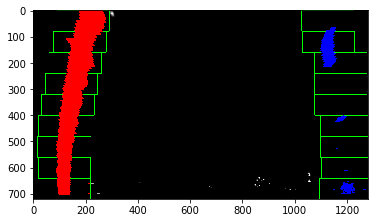

In [117]:
out_img, ori_out_img, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
plt.imshow(out_img)

### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

Since I've gotten the polynomial curve function for left/right driving lines above, so first of all I need to get middle polynomial curve from left/right curve, by average the left/right x-axis coordination, we can get the average x coordinations, and using the y coordinations and np.polyfit() above, the middle curve can be calculated easily.

by using the middle polynomial parameters above the curvature can be calculated as follow:
```
mid_curverad = (1+((2*mid_fit[0]*y_eval+mid_fit[1])**2)**(3//2))/(np.abs(2*mid_fit[0])) 
```

by counting the number of pixels regarding to center of camera and center of driving lane, and multiple by each pixel distance, we can get the positioin of the vehicle repect to center
```
mid_distance= (car_midpoint - camera_midpoint)*pixel_distance
```

In [90]:
def cal_radius(left_fitx, right_fitx, ploty):
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #calculate average middle line x coordinations 
    mid_fitx = (right_fitx+left_fitx)//2
    #find mid_fit parameter set
    mid_fit = np.polyfit(ploty, mid_fitx, 2)
    
    #calculate the middle line curvature
    mid_curverad = (1+((2*mid_fit[0]*y_eval+mid_fit[1])**2)**(3//2))/(np.abs(2*mid_fit[0]))  ## Implement the calculation of the left line here
    
    return mid_curverad, mid_fitx

#calculate the camera center and vehicle center distnace

def midpoints_dist(image, mid_fitx, left_fitx, right_fitx):
    # car & camera middle point pixel position
    car_midpoint = np.int(mid_fitx[0])
    camera_midpoint = np.int(image.shape[1]//2)
    
    #x direction pixel distant at bottom line
    xm_per_pix = 3.7/np.abs(right_fitx[0]-left_fitx[0])
    
    mid_dist = (car_midpoint - camera_midpoint)*xm_per_pix
    
    return mid_dist

Briefly showing the middle average line and the middle line's curvature and vehicle shifting distance repect to road middle line

middle curvature: 2965.1062917029667 m
shifting distance: 0.14964800112064247 m


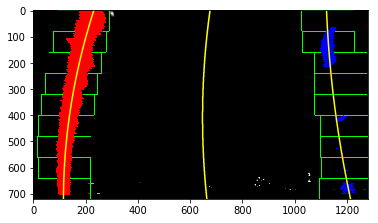

In [92]:
mid_curverad, mid_fitx = cal_radius(left_fitx, right_fitx, ploty)
mid_dist = midpoints_dist(img, mid_fitx, left_fitx, right_fitx)

print 'middle curvature:', mid_curverad, 'm'
print 'shifting distance:', mid_dist, 'm'

fig = plt.figure()
plt.imshow(out_img)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.plot(mid_fitx, ploty, color='yellow')

### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

When flip the source points and image points when you do the prespective transfrom from reginal masking road to plane view, you can easily get the Minv parameter set. 
So that you can use cv2.warpPrespective() with Minv to convert the prespective transformed image back to the nomral camera image shape easily. 
Then using the cv2.addWeighted() to combine the original image with the detected road lines

For better view perspective, I define the draw_data function to draw the real-time vehicle respect to driving lane center and curvature radius on images

In [96]:
#drawing road cruvature and vehicel shift distance on final output image

def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [107]:
def prespective_trans_reverse(img, detected_lane, left_fitx, right_fitx, ploty, Minv):
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(detected_lane, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(detected_lane, Minv, (detected_lane.shape[1], detected_lane.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
    
    return result

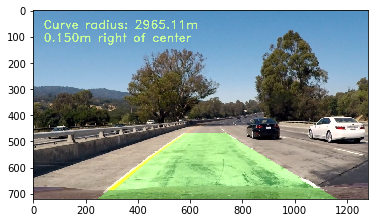

In [118]:
img = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\test_images\test1.jpg')
chesseboard = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\camera_cal\calibration3.jpg')

# doing camera calibration work
undistorted, warped, M, mtx,dist = cal_undistort_unwarped(chesseboard, objpoints, imgpoints)
undistorted_road = roadimg_unwarp(img, mtx, dist)
# save_fig(undistorted_road)

# formal transfrom road pic
road_mask = region_mask(undistorted_road)
combined__binary = combine_threshold(road_mask, ksize=9, grad_rangex=[40,150], grad_rangey=[70,150], mag_range=[70,150], dir_range=[np.pi/6, np.pi/2], hls_range=[100,255])
binary_warped, M, Minv = pres_trans(combined__binary)
detected_lane, original_lane, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
mid_curverad, mid_fitx = cal_radius(left_fitx, right_fitx, ploty)
result = prespective_trans_reverse(img, original_lane, left_fitx, right_fitx, ploty, Minv)

shift_dist = midpoints_dist(img, mid_fitx, left_fitx, right_fitx)
result_w_info = draw_data(original_img=result, curv_rad=mid_curverad, center_dist=shift_dist)
# show_img(img,undistorted_road, road_mask, combined__binary, binary_warped)
plt.imshow(result_w_info)

### Pipeline (video)

### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

The following pipeline function is overall combination of all functions

please check out throughput result at youtube [video link](https://www.youtube.com/watch?v=-B75qTmmtvQ)

In [122]:
chesseboard = plt.imread(r'C:\Users\caoxi\Desktop\XC Autopilot\CarND-Advanced-Lane-Lines-master\camera_cal\calibration3.jpg')
# doing camera calibration work
undistorted, warped, M, mtx_chess, dist_chess = cal_undistort_unwarped(chesseboard, objpoints, imgpoints)


def combine_all(img, 
                mtx=np.array([[1.38960165e+03, 0.00000000e+00, 6.97776080e+02],[0.00000000e+00, 1.40306507e+03, 3.29181507e+02],[0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 
                dist=np.array([[-0.33339803, -0.43691967,  0.0222618 , -0.00317319,  1.66535161]]), 
                ksize= 9,
                grad_rangex=[40,150],
                grad_rangey=[70,150],
                mag_range=[70,150],
                dir_range=[np.pi/6, np.pi/2], 
                hls_range=[100,255]):
    
    # save_fig(undistorted_road)
    undistorted_road = roadimg_unwarp(img, mtx, dist)
    # formal transfrom road pic
    road_mask = region_mask(undistorted_road)
    combined__binary = combine_threshold(road_mask, ksize, grad_rangex, grad_rangey, mag_range, dir_range, hls_range)
    binary_warped, M, Minv = pres_trans(combined__binary)
    detected_lane, original_lane, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
    mid_curverad, mid_fitx = cal_radius(left_fitx, right_fitx, ploty)
    result = prespective_trans_reverse(img, original_lane, left_fitx, right_fitx, ploty, Minv)
    shift_dist = midpoints_dist(img, mid_fitx, left_fitx, right_fitx)
    result_w_info = draw_data(result, mid_curverad, shift_dist)
    
    return result_w_info

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = combine_all(img=image, 
                        mtx=np.array([[1.38960165e+03, 0.00000000e+00, 6.97776080e+02],[0.00000000e+00, 1.40306507e+03, 3.29181507e+02],[0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 
                        dist=np.array([[-0.33339803, -0.43691967,  0.0222618 , -0.00317319,  1.66535161]]), 
                        ksize= 9,
                        grad_rangex=[40,150],
                        grad_rangey=[70,150],
                        mag_range=[70,150],
                        dir_range=[np.pi/6, np.pi/2], 
                        hls_range=[100,255])
    
    return result

In [123]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
project_clip = VideoFileClip('project_video.mp4')
processed_video = project_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_video.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:26<00:00,  3.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 27s


### Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

the most important part I think is to take care of the image matrix values' type, I stuck on the image converstion very long time because of this. all image has to be at same type and also when you forcely conver the binary gray image to RGB format, you should multiple all vlaues by 255 to fulfil the scale RGB using.

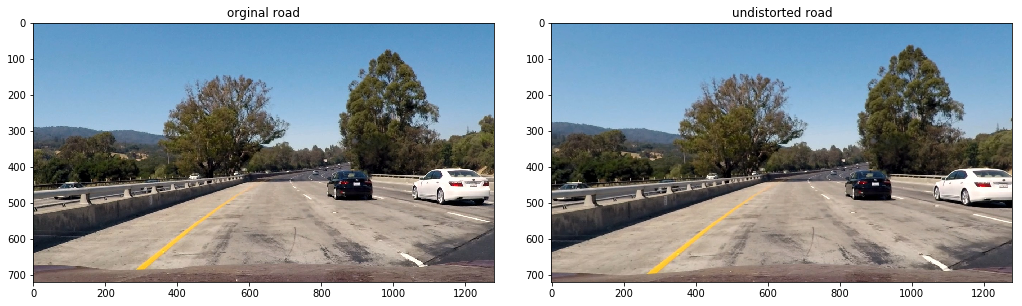

In [34]:
project_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
project_clip = VideoFileClip('challenge_video.mp4')
processed_video = project_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_video.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:10<00:00,  3.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 2min 11s


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [35]:
project_output = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
project_clip = VideoFileClip('harder_challenge_video.mp4')
processed_video = project_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time processed_video.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


 41%|████████████████████████████████▍                                              | 492/1200 [02:18<03:08,  3.75it/s]

TypeError: expected non-empty vector for x

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def tellme(self):
        if self.detected == True:
            print('true')
        else:
            print('False')

In [109]:
#sliding window
def fill_driveroad(out_img, left_fitx, right_fitx, ploty, margin = 100):
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result